In [2]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [3]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
nan_data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

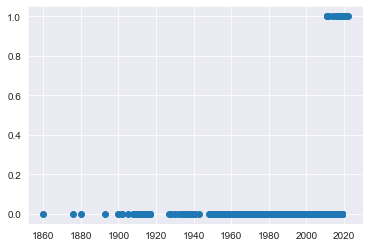

In [4]:
buildings_nnan = buildings.dropna()
apart_nnan = apartments.dropna()
plt.scatter(buildings_nnan["constructed"], buildings_nnan["new"])

data = pd.merge(apart_nnan, buildings_nnan.set_index('id'), how='left', left_on='building_id', right_index=True)

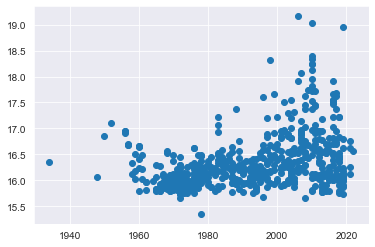

In [5]:
plt.scatter(data["constructed"], np.log(data["price"]))

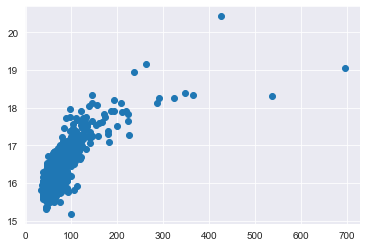

In [6]:
plt.scatter(data["area_total"], np.log(data["price"]))

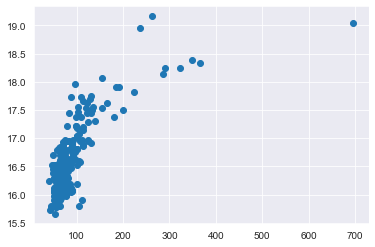

In [7]:
test = data[data["constructed"] > 2000]
plt.scatter(test["area_total"], np.log(test["price"]))

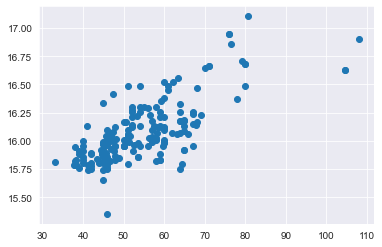

In [8]:
test = data[data["constructed"] < 1980]
plt.scatter(test["area_total"], np.log(test["price"]))

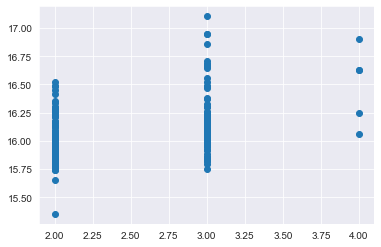

In [9]:
plt.scatter(test["rooms"], np.log(test["price"]))

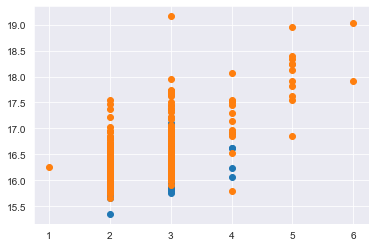

In [10]:
test2 = data[data["constructed"] < 1980]
plt.scatter(test2["rooms"], np.log(test2["price"]))
test3 = data[data["constructed"] > 2000]
plt.scatter(test3["rooms"], np.log(test3["price"]))

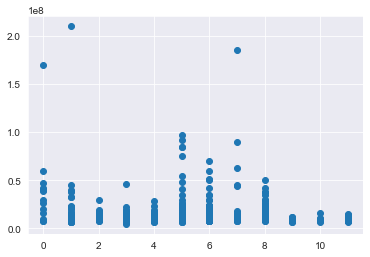

In [11]:
plt.scatter(data["district"], data["price"])

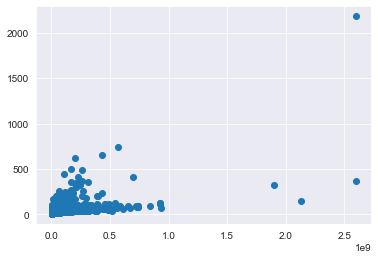

In [76]:
avg_room = nan_data["area_total"] / nan_data["rooms"]
plt.scatter(nan_data["price"], avg_room)

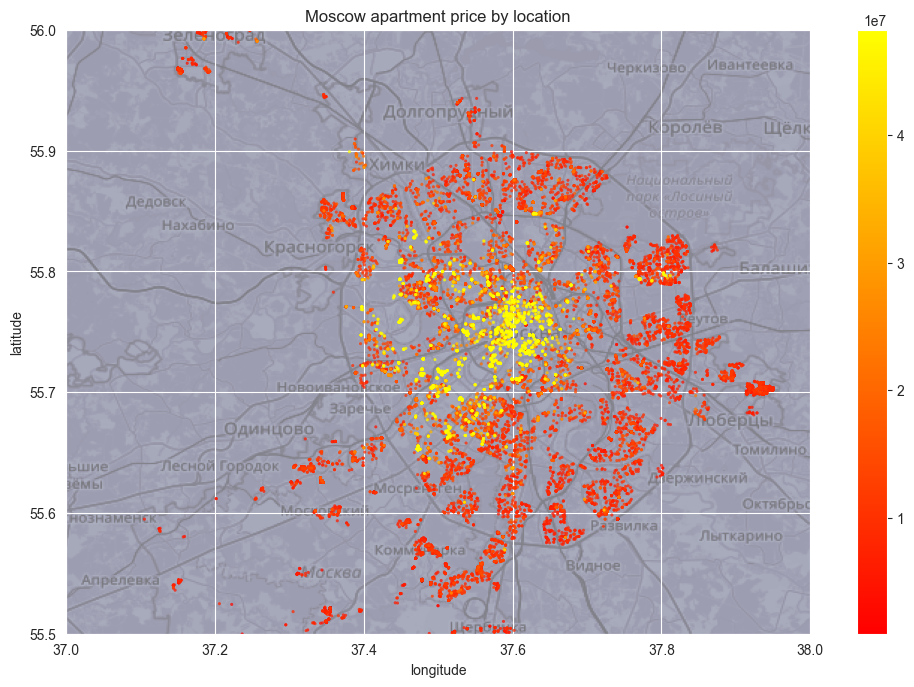

In [12]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('resources/data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(nan_data);

(<AxesSubplot:title={'center':'Moscow apartment price by location'}, xlabel='longitude', ylabel='latitude'>,
 None)

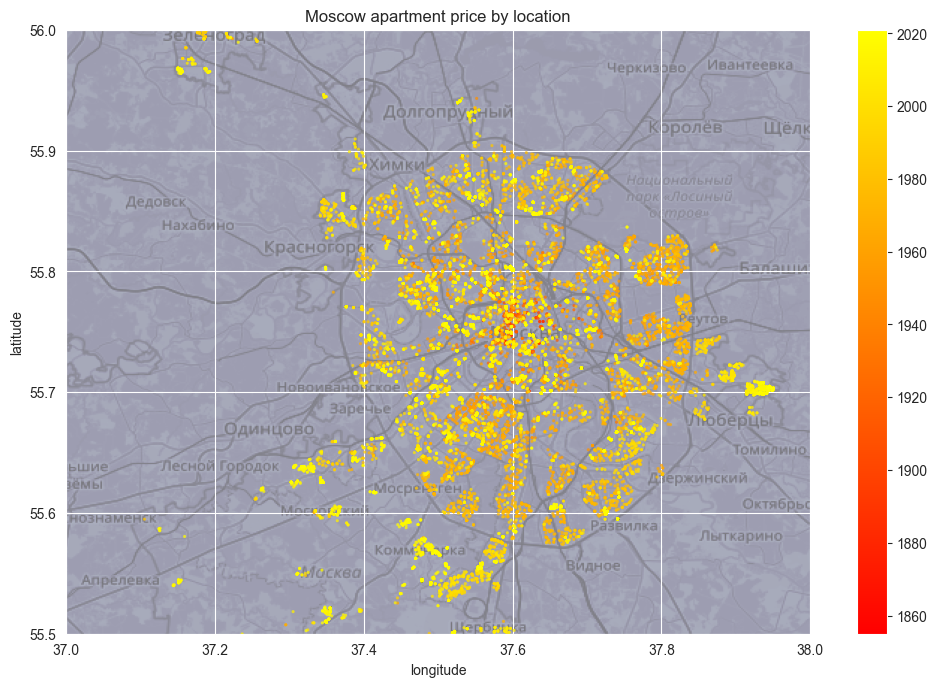

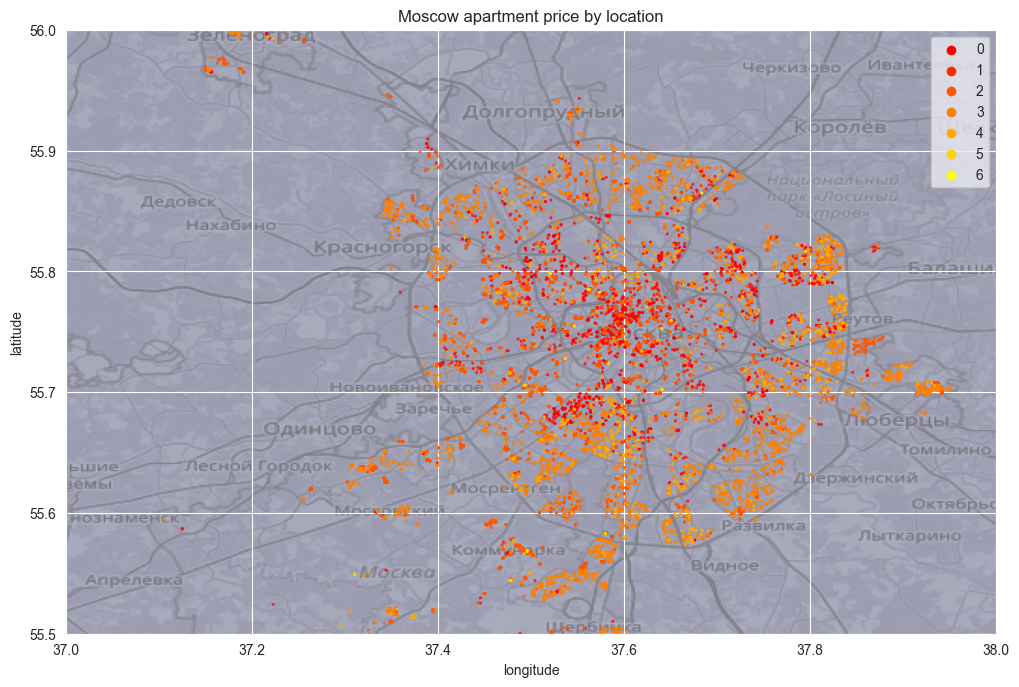

In [13]:
plot_map(nan_data, column="constructed")
plot_map(nan_data, column="material")

In [101]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


In [102]:
from sklearn.preprocessing import minmax_scale

nn_data = nan_data.copy()


print(min(nn_data["longitude"]))
print(max(nn_data["longitude"]))

print(min(nn_data["latitude"]))
print(max(nn_data["latitude"]))

nn_data = nn_data[nn_data["longitude"] > 36.0]
nn_data = nn_data[nn_data["longitude"] < 39.0]

nn_data = nn_data[nn_data["latitude"] > 54.0]
nn_data = nn_data[nn_data["latitude"] < 57.0]



distance = np.sqrt((37.6 - nn_data["longitude"])**2 + (55.75 - nn_data["latitude"])**2)

nn_data["distance"] = minmax_scale(distance)


nn_data = nn_data[~nn_data["constructed"].isna()]

scaler = MinMaxScaler()
nn_data["norm_const"] = minmax_scale(nn_data["constructed"])

print(nn_data.count())




36.864371000000006
37.950668
55.21143000000001
56.00650699999999
id                    22491
seller                14175
price                 22491
area_total            22491
area_kitchen          18009
area_living           18850
floor                 22491
rooms                 22491
layout                 5425
ceiling               11935
bathrooms_shared      18855
bathrooms_private     18855
windows_court         14731
windows_street        14731
balconies             12391
loggias               12391
condition             13001
phones                22431
building_id           22491
new                   22358
latitude              22491
longitude             22491
district              22361
street                22491
address               22491
constructed           22491
material              19110
stories               22491
elevator_without      22347
elevator_passenger    22347
elevator_service      22347
parking               16253
garbage_chute         14278
heating    

In [135]:
import torch
from torch import nn

In [140]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(6, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        res = self.linear_stack(x)
        return res

In [141]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log1p(pred + 1), torch.log1p(actual + 1)))

In [142]:
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

criterion = RMSLELoss()

X = np.array(nn_data[["area_total", "distance", "rooms", "norm_const", "stories", "floor"]])
Y = np.array(nn_data["price"])

X = torch.from_numpy(X)
X = X.type(torch.FloatTensor)

Y = torch.from_numpy(Y)
Y = Y.type(torch.FloatTensor)

for i in range(3000):
    pred = model(X)
    loss = criterion(pred.flatten(), Y)
    if (i % 100) == 0:
        print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(loss)
    
    
    

tensor(14.1382, grad_fn=<SqrtBackward>)
tensor(10.5747, grad_fn=<SqrtBackward>)
tensor(9.7812, grad_fn=<SqrtBackward>)
tensor(9.2792, grad_fn=<SqrtBackward>)
tensor(8.9081, grad_fn=<SqrtBackward>)
tensor(8.6127, grad_fn=<SqrtBackward>)
tensor(8.3669, grad_fn=<SqrtBackward>)
tensor(8.1563, grad_fn=<SqrtBackward>)
tensor(7.9719, grad_fn=<SqrtBackward>)
tensor(7.8080, grad_fn=<SqrtBackward>)
tensor(7.6604, grad_fn=<SqrtBackward>)
tensor(7.5262, grad_fn=<SqrtBackward>)
tensor(7.4031, grad_fn=<SqrtBackward>)
tensor(7.2894, grad_fn=<SqrtBackward>)
tensor(7.1837, grad_fn=<SqrtBackward>)
tensor(7.0851, grad_fn=<SqrtBackward>)
tensor(6.9926, grad_fn=<SqrtBackward>)
tensor(6.9055, grad_fn=<SqrtBackward>)
tensor(6.8232, grad_fn=<SqrtBackward>)
tensor(6.7452, grad_fn=<SqrtBackward>)
tensor(6.6711, grad_fn=<SqrtBackward>)
tensor(6.6005, grad_fn=<SqrtBackward>)
tensor(6.5331, grad_fn=<SqrtBackward>)
tensor(6.4686, grad_fn=<SqrtBackward>)
tensor(6.4068, grad_fn=<SqrtBackward>)
tensor(6.3475, grad_fn=

In [177]:
pred_a = model(X)
print(pred_a)

tensor([[35269.7695],
        [26863.0566],
        [19912.6738],
        ...,
        [40207.6367],
        [26700.7070],
        [20576.9492]], grad_fn=<ReluBackward0>)


In [178]:
t_apartments = pd.read_csv('resources/data/apartments_test.csv')
t_buildings = pd.read_csv('resources/data/buildings_test.csv')
test_data_a = pd.merge(t_apartments, t_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
X_test_nan_a = test_data_a.isna().any(axis=1)
test_data = test_data_a.copy()

test_data.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


In [179]:
test_data = test_data[test_data["longitude"] > 36.0]
test_data = test_data[test_data["longitude"] < 39.0]

test_data = test_data[test_data["latitude"] > 54.0]
test_data = test_data[test_data["latitude"] < 57.0]



distance = np.sqrt((37.6 - test_data["longitude"])**2 + (55.75 - test_data["latitude"])**2)

test_data["distance"] = minmax_scale(distance)


test_data = test_data[~test_data["constructed"].isna()]

scaler = MinMaxScaler()
test_data["norm_const"] = minmax_scale(test_data["constructed"])

test_data = test_data[["area_total", "distance", "rooms", "norm_const", "stories", "floor"]]
X_test_nan = test_data.isna().any(axis=1)
print(X_test_nan)
X = np.array(test_data[~X_test_nan])

X = torch.from_numpy(X)
X = X.type(torch.FloatTensor)

pred_b = model(X)
print(pred_b)

0       True
1       True
2       True
3       True
4       True
        ... 
9932    True
9933    True
9934    True
9935    True
9936    True
Length: 9937, dtype: bool
tensor([[ 33790.0312],
        [ 30840.0098],
        [ 37177.2656],
        [ 38100.6094],
        [ 41683.1523],
        [ 47261.9570],
        [ 47277.3945],
        [ 23652.6738],
        [ 26390.9316],
        [ 20796.3340],
        [ 45301.8359],
        [ 37840.8789],
        [ 27889.1582],
        [ 29132.3535],
        [ 35034.0156],
        [ 50041.3945],
        [ 68202.6172],
        [ 35798.9258],
        [ 42613.1602],
        [ 20518.4531],
        [ 18822.9766],
        [ 20078.4219],
        [ 21024.6191],
        [ 25899.1934],
        [ 30807.8652],
        [ 26420.3867],
        [ 31406.4707],
        [ 29745.1699],
        [ 32632.4668],
        [ 43898.3203],
        [ 34862.7539],
        [ 32963.9297],
        [ 39293.2617],
        [ 29082.7188],
        [ 49499.8125],
        [ 51268.9805],
   

C:\Users\mikol\AppData\Local\Temp/ipykernel_20956/293221258.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = np.array(test_data[~X_test_nan])


In [183]:

submission = pd.DataFrame()
submission['id'] = test_data_a["id"]
submission.loc[~X_test_nan, 'price_prediction'] = pred_b.detach().numpy() # Predict on non-nan entries
submission['price_prediction'].fillna(y_train.mean(), inplace=True)
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l sample_submission.csv


C:\Users\mikol\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


TypeError: unhashable type: 'Series'